In [1]:
import queue
import csv
import pandas as pd
import re
import ast

In [2]:
class Vulnerability:
    title = ""
    severity = ""
    transPath = []
    isUpgradable = False
    upgradePath = []
    isPatchable = False
    isPinnable = False
    
    def __init__(self, title, severity, transPath, isUpgradable, upgradePath, isPatchable, isPinnable):
        self.title = title
        self.severity = severity
        self.transPath = transPath
        self.isUpgradable = isUpgradable
        self.upgradePath = upgradePath
        self.isPatchable = isPatchable
        self.isPinnable = isPinnable
        
    def get_root(self):
        if len(self.transPath) == 0:
            print("Error: no vulnerability has been detected.")
            return None, None
        else:
            root = self.transPath[-1]
            name, version = root.split("@")
            return name, version
        
    def get_path_length(self):
        return len(self.transPath)

In [3]:
class Node:
    projectId = -1
    projectName = ""
    vulnCounts = [0, 0, 0]
    vulnList = []
    version = "0.0.0"
    timestamp = ""
    directReach = set() # all packages directly dependent on this node
    directTrust = set() # all pacakges directly dependent by this node
    
    def __init__(self, pid, pname, version, timestamp):
        self.projectId = pid
        self.projectName = pname
        self.version = version
        self.timestamp = timestamp
        self.vulnCounts = [0, 0, 0]
        self.vulnList = []
        self.directReach = set()
        self.directTrust = set()
        
    def description(self):
        print(f"Project ID:{self.projectId}")
        print(f"Project Name:{self.projectName} Version:{self.version}")
        print(f"Published Time:{self.timestamp}")
        if self.vulnCounts[0] > 0:
            print(f"Original Vulnerability: {self.vulnCounts[0]}")
        if self.vulnCounts[1] > 0:
            print(f"Direct Dependent Vulnerability: {self.vulnCounts[1]}")
        if self.vulnCounts[2] > 0:
            print(f"Direct Independent Vulnerability: {self.vulnCounts[2]}")
        print(f"{len(self.directReach)} packages are directly dependent on the node.")
        print(f"{len(self.directTrust)} packages are directly dependent by the node.")
        
    def is_vuln(self):
        print(sum(self.vulnCounts) > 0)
        
    def update_deps(self, edges):
        for e in edges:
            if e[0] == self.projectId:
                self.directTrust.add(e[1])
            if e[1] == self.projectId:
                self.directReach.add(e[0])
                
    def update_vulns(self, v):
        for vuln in self.vulnList:
            if v.title == vuln.title:
                return
        path_length = v.get_path_length()
        if path_length == 1:
            self.vulnCounts[0] += 1
        elif path_length == 2:
            self.vulnCounts[1] += 1
        elif path_length > 2:
            self.vulnCounts[2] += 1
        self.vulnList.append(v)  

In [4]:
class DiGraph: 
    nodes = set()
    edges = set()
    
    def __init__(self, nodeList, edgeList):
        for n in nodeList:
            self.nodes.add(n.projectId)
        self.edges = edgeList
    
    def add_node(self, pid, n):
        self.nodes.add(pid)
        nodeMap[pid] = n
    
    def add_edge(self, e):
        self.edges.add(e)
        
    def update_direct_reach_trust(self):
        k = 0
        for pid, n in nodeMap.items():
            n.update_deps(self.edges)
            k += 1
            if k % 1000 == 0:
                print(f"{k} of {len(self.nodes)} nodes updated.")
    
    def PR(self, pid):
        q = queue.Queue()
        q.put(pid)
        vertices = []
        print(f"Start finding projects dependent on {nodeMap[pid].projectName}.")
        while q.empty() == False:
            v = q.get()
            #print(nodeMap[v].projectName)
            for e in self.edges:
                if v == e[1] and e[0] not in vertices:
                    vertices.append(e[0])
                    q.put(e[0])
        print(f"{len(vertices)} projects dependent on {nodeMap[pid].projectName}.")
        return vertices
    
    def ITP(self, pid):
        q = queue.Queue()
        q.put(pid)
        vertices = []
        while(q.empty() == False):
            v = q.get()
            for e in self.edges:
                if v == e[0] and e[1] not in vertices:
                    vertices.append(e[1])
                    q.put(e[1])
        return vertices
    
    def find_path(self, fid, tid):
        q = queue.Queue()
        q.put(fid)
        path = []
        backList = [-1]
        vertices = []
        while len(backList) < 100000:
            v = q.get()
            bidx = len(backList) - 1
            for e in self.edges:
                if v == e[0] and e[1] not in vertices:
                    backList.append(bidx)
                    vertices.append(e[1])
                    if e[1] == tid:
                        path.append(tid)
                        while bidx != -1:
                            path.append(vertices[bidx])
                            bidx = backList[bidx]
                        break
                    q.put(e[1])
            if len(path) > 0:
                for pid in reversed(path):
                    n = nodeMap[pid]
                    ans.append(n.projectName + '@' + n.version)
                ans.append(nodeMap[fid].projectName + '@' + nodeMap[fid].version)
                return ans
        return None
    
    def flag_vulns(self, popVulnList):
        k = 0
        for pid in popVulnList:
            node = nodeMap[pid]
            if sum(node.vulnCounts) > 0:
                reach = set(self.PR(pid))
                for p in reach:
                    n = nodeMap[p]
                    for i, v in enumerate(node.vulnList):
                        tp = self.find_path(pid, p)
                        if tp is not None:
                            n.update_vulns(Vulnerability(v.title, v.severity, tp[:-1] + v.transPath, v.isUpgradable, v.upgradePath, v.isPatchable, v.isPinnable))
                        print(f"{i} vulnerabilities have been updated.")
            k += 1
            print(f"{k} of {len(popVulnList)} packages have been updated.")

In [5]:
def atoi(s):
    ret = re.findall(r"^\d+", s.strip())
    if ret:
        return int(ret[0])
    return 0

In [6]:
# 1.1.x = ~1.1.0
# 1.x.x = ^1.0.0
def vercmp(v1, v2):
    f1 = False
    f2 = False
    f3 = False
    f4 = False
    if len(v1) == 0 or len(v2) == 0:
        return 0
    if v1 == '*' or v2 == '*':
        return 0
    try:
        a1, b1, c1 = v1.split('.', 2)
    except ValueError:
        try:
            a1, b1 = v1.split('.', 1)
            c1 = 'x'
        except ValueError:
            a1 = v1
            b1 = 'x'
            c1 = 'x'
    try:
        a2, b2, c2 = v2.split('.', 2)
    except ValueError:
        try:
            a2, b2 = v2.split('.', 1)
            c2 = 'x'
        except ValueError:
            a2 = v2
            b2 = 'x'
            c2 = 'x'
    if len(a1) == 0:
        a1 = '0'
    if len(a2) == 0:
        a2 = '0'
    if a1[0] == '^':
        f1 = True
        a1 = a1[1:]
    elif a1[0] == '~':
        f2 = True
        a1 = a1[1:]
    elif a1[0:2] == '>=':
        f3 = True
        a1 = a1[2:]
    elif a1[0] == '>':
        f3 = True
        a1 = a1[1:]
    elif a1[0:2] == '<=':
        f4 = True
        a1 = a1[2:]
    elif a1[0] == '<':
        f4 = True
        a1 = a1[1:]
    if a2[0] == '^':
        f1 = True
        a2 = a2[1:]
    elif a2[0] == '~':
        f2 = True
        a2 = a2[1:]
    elif a2[0:2] == '>=':
        f4 = True
        a2 = a2[2:]
    elif a2[0] == '>':
        f4 = True
        a2 = a2[1:]
    elif a2[0:2] == '<=':
        f3 = True
        a2 = a2[2:]
    elif a2[0] == '<':
        f3 = True
        a2 = a2[1:]
    
    try:
        if a1 == 'x' or a2 == 'x':
            return 0
        if atoi(a1) > atoi(a2):
            if f4 == True:
                return 0
            return 1
        if atoi(a1) < atoi(a2):
            if f3 == True:
                return 0
            return -1
        if atoi(a1) == atoi(a2):
            if f1 == True:
                return 0
            if b1 == 'x' or b2 == 'x':
                return 0
            if atoi(b1) > atoi(b2):
                if f4 == True:
                    return 0
                return 1
            if atoi(b1) < atoi(b2):
                if f3 == True:
                    return 0
                return -1
            if atoi(b1) == atoi(b2):
                if f2 == True:
                    return 0
                if c1 == 'x' or c2 == 'x':
                    return 0
                if atoi(c1) > atoi(c2):
                    if f4 == True:
                        return 0
                    return 1
                if atoi(c1) < atoi(c2):
                    if f3 == True:
                        return 0
                    return -1
                if atoi(c1) == atoi(c2):
                    return 0
    except ValueError:
        return 0

In [7]:
nodeList = []

with open("npm/(NPM_extracted)projects-1.6.0-2020-01-12.csv", 'r', encoding='utf-8') as f:
    proj_file = csv.reader(f)
    header = next(proj_file)
    old_n = None
    for row in proj_file:
        n = Node(row[0], row[2], row[13], row[12])
        nodeList.append(n)

In [8]:
nodeMap = {}
name2id = {}

for n in nodeList:
    nodeMap[n.projectId] = n
    name2id[n.projectName] = n.projectId

In [9]:
edgeList = []

with open("npm/(NPM_extracted)dependencies-1.6.0-2020-01-12.csv", 'r', encoding='utf-8') as f:
    dep_file = csv.reader(f)
    header = next(dep_file)
    print(header)
    for row in dep_file:
        if row[8] != 'runtime' or row[7] != 'NPM':
            continue
        fid = row[3]
        fver = row[4]
        if fid != '' and fid in nodeMap.keys():
            fromNode = nodeMap[fid]
            if vercmp(fromNode.version, fver) == 0:
                tid = row[-1]
                tver_range = row[-2]
                if tid != '' and tid in nodeMap.keys():
                    toNode = nodeMap[tid]
                    if vercmp(toNode.version, tver_range) == 0:
                        edgeList.append((fid, tid))
                        if len(edgeList) % 100000 == 0:
                            print(f"{len(edgeList)} edges have been record.")

['ID', 'Platform', 'Project Name', 'Project ID', 'Version Number', 'Version ID', 'Dependency Name', 'Dependency Platform', 'Dependency Kind', 'Optional Dependency', 'Dependency Requirements', 'Dependency Project ID']
100000 edges have been record.
200000 edges have been record.
300000 edges have been record.
400000 edges have been record.
500000 edges have been record.
600000 edges have been record.
700000 edges have been record.
800000 edges have been record.
900000 edges have been record.
1000000 edges have been record.
1100000 edges have been record.
1200000 edges have been record.
1300000 edges have been record.
1400000 edges have been record.
1500000 edges have been record.
1600000 edges have been record.
1700000 edges have been record.
1800000 edges have been record.
1900000 edges have been record.
2000000 edges have been record.
2100000 edges have been record.
2200000 edges have been record.
2300000 edges have been record.
2400000 edges have been record.
2500000 edges have been 

In [10]:
dep_graph = DiGraph(nodeList, edgeList)

In [56]:
import networkx as nx
G = nx.DiGraph()

In [57]:
with open("npm/(NPM_extracted)projects-1.6.0-2020-01-12.csv", 'r', encoding='utf-8') as f:
    proj_file = csv.reader(f)
    header = next(proj_file)
    old_n = None
    for row in proj_file:
        G.add_node(row[0])

In [58]:
with open("npm/(NPM_extracted)dependencies-1.6.0-2020-01-12.csv", "r", encoding='utf-8') as csvfile:
    datareader = csv.reader(csvfile)
    next(datareader) # remove header
    for row in datareader:
        dep_kind = row[8]
        dep_plat = row[7]

    # Consider 'runtime' and 'optional' dependencies
    # Exclude non-npm dependency
        isRuntime = dep_kind != 'Development'
        isNPM = dep_plat == 'NPM'
        if isRuntime and isNPM:
            id = row[3]
            dep_id = row[-1]
            G.add_edge(dep_id, id) # Edge between two nodes represents dependency

In [25]:
s1 = set(edgeList)
s2 = set(G.edges)
su = s1 & s2
len(su) / len(s2)

0.47771548156740623

In [11]:
popVulnSet = set()
rootVulnSet = set()

with open("npm/top_2000_package_release_vulnCount_had_vuln_vulnDetails.tsv", "r") as f:
    vul_file = csv.reader(f, delimiter="\t", quotechar='"')
    header = next(vul_file)
    print(header)
    for k, row in enumerate(vul_file):
        rawPath = row[14].replace(' ', '')
        rawPath = rawPath[1:-1]
        isPinnable = (row[-1] == 'TRUE')
        isPatchable = (row[-2] == 'TRUE')
        isUpgradable = (row[-3] == 'TRUE')
        name = row[3]
        root = row[16]
        if name in name2id.keys():
            node = nodeMap[name2id[name]]
            if vercmp(node.version, row[4]) == 0: 
                popVulnSet.add(node.projectId)
                if root in name2id.keys():
                    rootVulnSet.add(root)
                    rootNode = nodeMap[name2id[root]]
                    if vercmp(rootNode.version, row[17]) == 0:
                        rootNode.update_vulns(Vulnerability(row[13], row[12], [root + '@' + row[17]], isUpgradable, row[-4], isPatchable, isPinnable))
                node.update_vulns(Vulnerability(row[13], row[12], list(rawPath.split(',')), isUpgradable, row[-4], isPatchable, isPinnable))
        k += 1
        if k > 0 and k % 100000 == 0:
            print(f"{k} rows have been scanned")

['X', 'Rank', 'Language', 'Name', 'Release.Name', 'Release.Time', 'is_ok', 'vulnIndex', 'creationTime', 'disclosureTime', 'modificationTime', 'publicationTime', 'severity', 'title', 'path', 'pathDepth', 'rootPackage', 'rootPackageVersion', 'upgradePath', 'isUpgradable', 'isPatchable', 'isPinnable']
100000 rows have been scanned
200000 rows have been scanned
300000 rows have been scanned
400000 rows have been scanned
500000 rows have been scanned
600000 rows have been scanned
700000 rows have been scanned
800000 rows have been scanned
900000 rows have been scanned
1000000 rows have been scanned
1100000 rows have been scanned
1200000 rows have been scanned
1300000 rows have been scanned
1400000 rows have been scanned
1500000 rows have been scanned
1600000 rows have been scanned


In [61]:
vertices = list(popVulnSet)
q = queue.Queue()
for pid in popVulnSet:
    q.put(pid)
while q.empty() != True:
    i = q.get()
    new = []
    if i in list(G.nodes):
        new = list(G.neighbors(i))
    for pid in new:
        if pid not in vertices:
            q.put(pid)
    vertices += list(set(vertices + new))
len(vertices)

KeyboardInterrupt: 

In [60]:
G.number_of_nodes()

1275525

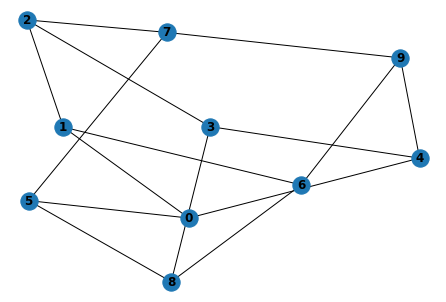

In [38]:
G = nx.petersen_graph()
nx.draw(G, with_labels=True, font_weight='bold')

In [13]:
vertices = []
for pid in popVulnSet:
    vertices.append(dep_graph.PR(pid))
vertices = list(set(vertices))

Start finding projects dependent on mout.
699 projects dependent on mout.
Start finding projects dependent on material-ui.


KeyboardInterrupt: 

In [14]:
sample = pd.read_csv("npm/(NPM_extracted)dependencies-1.6.0-2020-01-12.csv", nrows=5)
sample

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
0,1080746,NPM,7,30621,0.0.1,18347,should,NPM,Development,False,~1.2.2,313128
1,1080747,NPM,7,30621,0.0.1,18347,mocha,NPM,Development,False,~1.12.0,295363
2,1080748,NPM,7,30621,0.0.2,18348,should,NPM,Development,False,~1.2.2,313128
3,1080749,NPM,7,30621,0.0.2,18348,mocha,NPM,Development,False,~1.12.0,295363
4,1080750,NPM,1,30622,0.0.1,18349,commander,NPM,runtime,False,1.0.x,137207
